# KNEE X RAY CLASSIFICATION

# BUSINESS PROBLEM
### As a machine learning expert in a healthcare organization, one of the orthopedic doctors has approached me to leverage my expertise. He has requested that I develop a machine learning model capable of identifying healthy knees and those affected by osteoporosis using knee X-rays and patient data. The goal is to enhance and expedite his decision-making process. Additionally, the models will be deployed using Streamlit to ensure a user-friendly interface for practical application.

In [7]:
import tensorflow as tf
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt 
from PIL import Image,ImageEnhance
import os
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score
from matplotlib.image import imread
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.models import load_model
import warnings
warnings.filterwarnings('ignore')

In [8]:
import kagglehub

path = kagglehub.dataset_download("sachinkumar413/osteoporosis-knee-dataset-preprocessed128x256")

print("Path to dataset files:", path)

Path to dataset files: /home/jovyan/.cache/kagglehub/datasets/sachinkumar413/osteoporosis-knee-dataset-preprocessed128x256/versions/1


In [9]:
os.listdir(path)

['Osteoporosis Knee Dataset']

In [10]:
data_dir = r'/home/jovyan/.cache/kagglehub/datasets/sachinkumar413/osteoporosis-knee-dataset-preprocessed128x256/versions/1/Osteoporosis Knee Dataset/'

In [11]:
os.listdir(data_dir)

['Normal', 'Osteoporosis']

pip install openpyxl

# Visualizing  osteoporosis images 

In [12]:
Osteoporosis_path = os.listdir(data_dir+'Osteoporosis')[0]

In [13]:
os_images =data_dir+'Osteoporosis/'+Osteoporosis_path


In [14]:
imread(os_images).shape

(256, 128, 3)

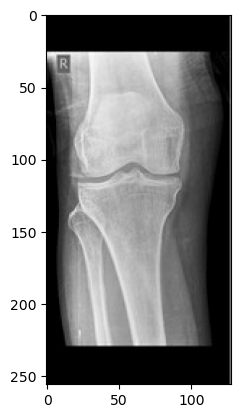

In [15]:
plt.imshow(imread(os_images))

## More Visualisation on Osteoporosis images

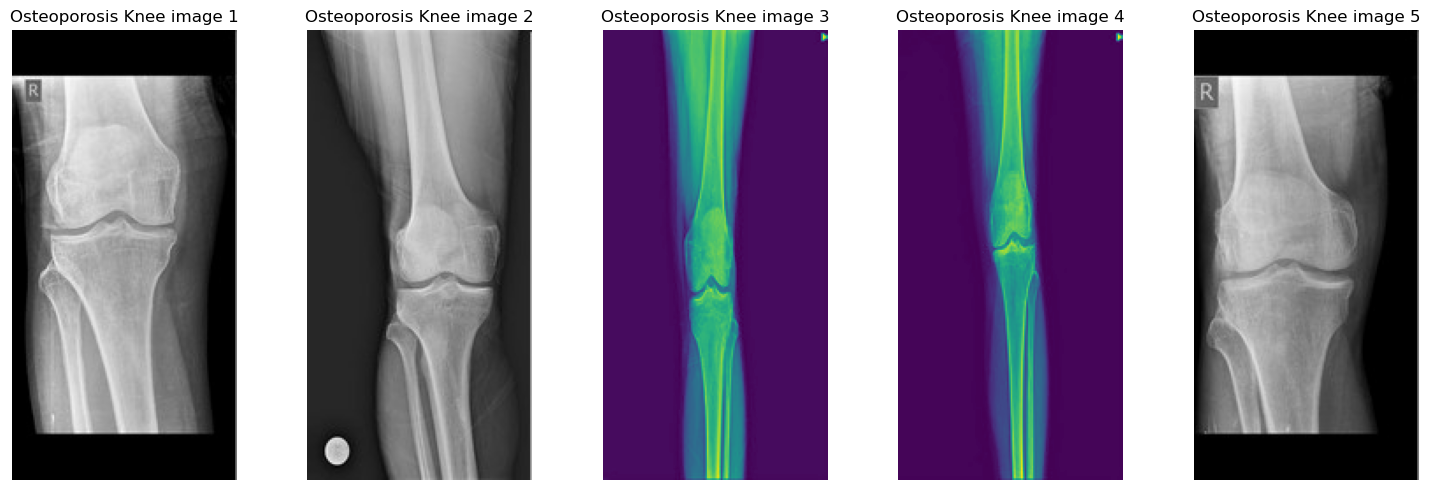

In [16]:

Osteoporosis_dir = os.path.join(data_dir, 'Osteoporosis')
image_files = os.listdir(Osteoporosis_dir)[:5]
fig, axes = plt.subplots(1, 5, figsize=(15, 5))  
for i, img_file in enumerate(image_files):
    img_path = os.path.join(Osteoporosis_dir, img_file)
    img = imread(img_path)
    axes[i].imshow(img)
    axes[i].axis('off') 
    axes[i].set_title(f"Osteoporosis Knee image {i+1}") 
plt.tight_layout()
plt.show()

# Visualizing Healthy images 

In [17]:
n_path = os.listdir(data_dir+'Normal')[0]

In [18]:
n_images =data_dir+'Normal/'+n_path

In [19]:
imread(n_images).shape

(256, 128)

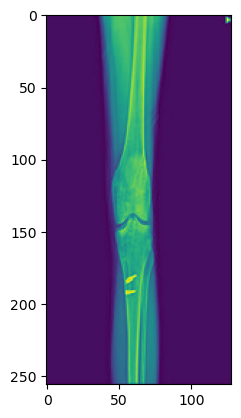

In [20]:
plt.imshow(imread(n_images))

## More Visualisation on healthy images

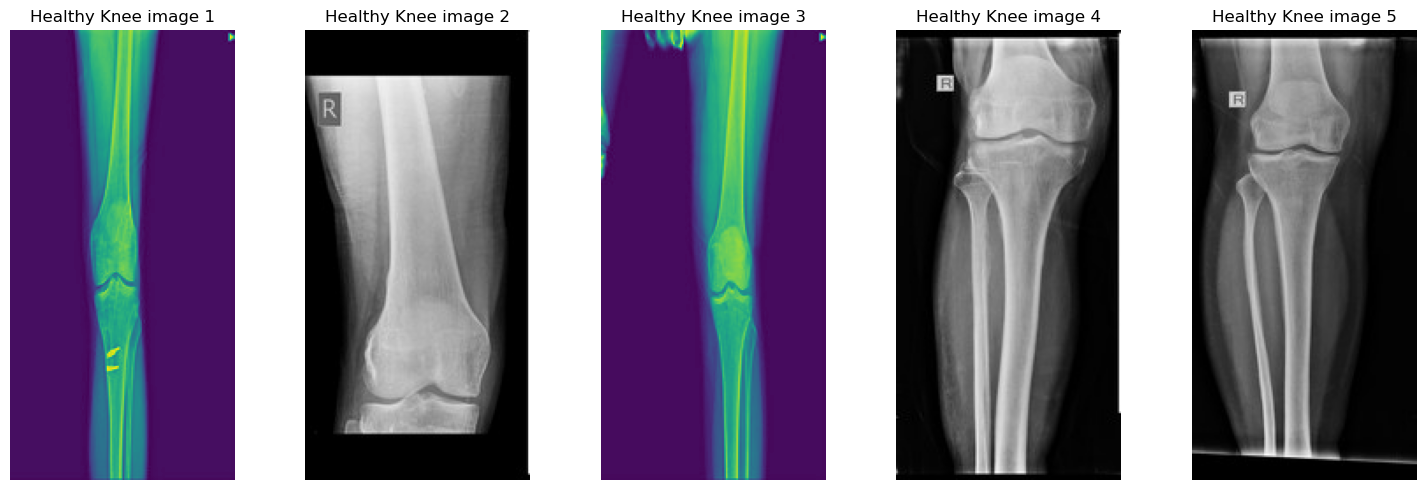

In [21]:

normal_dir = os.path.join(data_dir, 'Normal')
image_files = os.listdir(normal_dir)[:5]
fig, axes = plt.subplots(1, 5, figsize=(15, 5))  
for i, img_file in enumerate(image_files):
    img_path = os.path.join(normal_dir, img_file)
    img = imread(img_path)
    axes[i].imshow(img)
    axes[i].axis('off') 
    axes[i].set_title(f"Healthy Knee image {i+1}") 
plt.tight_layout()
plt.show()

In [22]:
# Getting the directory for each image class folder

healthy_dirs = r'/home/jovyan/.cache/kagglehub/datasets/sachinkumar413/osteoporosis-knee-dataset-preprocessed128x256/versions/1/Osteoporosis Knee Dataset/Normal'
osteoporosis_dirs =r'/home/jovyan/.cache/kagglehub/datasets/sachinkumar413/osteoporosis-knee-dataset-preprocessed128x256/versions/1/Osteoporosis Knee Dataset/Osteoporosis'


In [23]:
##  Looping through each folder with various file extensions and converting path of each image to a row 

healthy_dirs =healthy_dirs
osteoporosis_dirs=osteoporosis_dirs


filepaths = []
labels = []

dict_lists = [healthy_dirs, osteoporosis_dirs]
class_labels = ['Healthy', 'Osteoporosis']
image_extensions = (".jpg", ".jpeg", ".png", ".bmp", ".tiff")

for i, dir_list in enumerate(dict_lists):
    flist = os.listdir(dir_list)  
    for f in flist:
    
        if f.lower().endswith(image_extensions):  
            fpath = os.path.join(dir_list, f)  
            filepaths.append(fpath)  
            labels.append(class_labels[i]) 


In [24]:

# Creating  a DataFrame from the file paths and labels
Fseries = pd.Series(filepaths, name="filepaths")
Lseries = pd.Series(labels, name="labels")
knee_osteoporosis_data = pd.concat([Fseries, Lseries], axis=1)
knee_osteoporosis_df = pd.DataFrame(knee_osteoporosis_data)


In [25]:
knee_osteoporosis_df


,filepaths,labels
0,/home/jovyan/.cache/kagglehub/datasets/sachink...,Healthy
1,/home/jovyan/.cache/kagglehub/datasets/sachink...,Healthy
2,/home/jovyan/.cache/kagglehub/datasets/sachink...,Healthy
3,/home/jovyan/.cache/kagglehub/datasets/sachink...,Healthy
4,/home/jovyan/.cache/kagglehub/datasets/sachink...,Healthy
...,...,...
367,/home/jovyan/.cache/kagglehub/datasets/sachink...,Osteoporosis
368,/home/jovyan/.cache/kagglehub/datasets/sachink...,Osteoporosis
369,/home/jovyan/.cache/kagglehub/datasets/sachink...,Osteoporosis
370,/home/jovyan/.cache/kagglehub/datasets/sachink...,Osteoporosis


In [26]:
knee_osteoporosis_df.shape

(372, 2)

In [27]:
knee_osteoporosis_df['labels'].value_counts()

labels
Healthy         186
Osteoporosis    186
Name: count, dtype: int64

### My dataset lacks enough images to effectively train my model. To address this, I need to generate additional images using offline augmentation techniques

In [28]:

# Defining output folders for augmented images
output_dir = "./augmented_data"
classes = ["Healthy", "Osteoporosis"]
for class_name in classes:
    class_path = os.path.join(output_dir, class_name)
    os.makedirs(class_path, exist_ok=True)


In [29]:
# Creating  transformations function such as rotation, flipping,  and  brightness adjustments. 

def augment_and_save(image_path, save_dir, base_name):
    """Apply augmentations and save images."""
    image = Image.open(image_path)
    
    # Rotation
    for angle in [90, 180, 270]:
        rotated = image.rotate(angle)
        rotated.save(os.path.join(save_dir, f"{base_name}_rot{angle}.jpg"))
    
    # Flipping
    flipped = image.transpose(Image.FLIP_LEFT_RIGHT)
    flipped.save(os.path.join(save_dir, f"{base_name}_flip.jpg"))
    
    # Brightness adjustments
    enhancer = ImageEnhance.Brightness(image)
    for factor in [0.5, 1.5]:  # Darker and brighter versions
        brightened = enhancer.enhance(factor)
        brightened.save(os.path.join(save_dir, f"{base_name}_bright{factor}.jpg"))

# Loop through the DataFrame and apply augmentations
for index, row in knee_osteoporosis_df.iterrows():
    img_path = row["filepaths"]
    label = row["labels"]
    
    save_dir = os.path.join(output_dir, label)
    base_name = os.path.splitext(os.path.basename(img_path))[0]
    augment_and_save(img_path, save_dir, base_name)


In [30]:
# Rebuild DataFrame for augmented data
augmented_filepaths = []
augmented_labels = []

# Loop through augmented folders
for label in classes:
    class_folder = os.path.join(output_dir, label)
    files = os.listdir(class_folder)
    
    for file in files:
        augmented_filepaths.append(os.path.join(class_folder, file))
        augmented_labels.append(label)

# Create a DataFrame
augmented_df = pd.DataFrame({
    "filepaths": augmented_filepaths,
    "labels": augmented_labels
})


In [31]:
augmented_df

,filepaths,labels
0,./augmented_data/Healthy/N31_rot270_26.jpg,Healthy
1,./augmented_data/Healthy/N35_flip_7.jpg,Healthy
2,./augmented_data/Healthy/Normal_19_rot180.jpg,Healthy
3,./augmented_data/Healthy/N18_bright0.7_17.jpg,Healthy
4,./augmented_data/Healthy/Normal_113_rot270.jpg,Healthy
...,...,...
4575,./augmented_data/Osteoporosis/OS43_bright0.8_0...,Osteoporosis
4576,./augmented_data/Osteoporosis/OS17_bright1.5.jpg,Osteoporosis
4577,./augmented_data/Osteoporosis/OS34_rot180_0.jpg,Osteoporosis
4578,./augmented_data/Osteoporosis/OS43_flip_18.jpg,Osteoporosis


In [32]:

# Split the DataFrame into train and test sets and stratify the label to preserve my class distribution because  im going to perform flow from dataframe 

train_df, test_df = train_test_split(augmented_df,  test_size=0.2, stratify=augmented_df['labels'], random_state=42)

In [33]:
# Creating ImageDataGenerators to normalize and rescale my images

train_datagen = ImageDataGenerator(rescale=1./255)  
test_datagen = ImageDataGenerator(rescale=1./255) 

In [34]:
# Define the target size and batch size

TARGET_SIZE = (150, 150)  
BATCH_SIZE = 32


### Creating my Train and test generators

In [35]:
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='filepaths',  
    y_col='labels',     
    target_size=TARGET_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',  
    shuffle=True         
)

Found 3664 validated image filenames belonging to 2 classes.


In [36]:

# creating my test generator. it is not good to shuffle the test data 

test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col='filepaths',
    y_col='labels',
    target_size=TARGET_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False 
)


Found 916 validated image filenames belonging to 2 classes.


In [37]:
# Define a simple CNN model

model = Sequential([Conv2D(filters= 32, kernel_size= (3, 3), activation='relu', input_shape=(150, 150, 3)),
           MaxPooling2D(pool_size=(2, 2)),
          Flatten(),
          Dense(128, activation='relu'),
          Dense(1, activation='sigmoid') 
])

In [38]:

# Compile the model

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [39]:

# Train the model

history = model.fit(train_generator,validation_data=test_generator,epochs=10)


Epoch 1/10
115/115 ━━━━━━━━━━━━━━━━━━━━ 53s 449ms/step - accuracy: 0.5962 - loss: 1.0956 - val_accuracy: 0.8046 - val_loss: 0.4433
Epoch 2/10
115/115 ━━━━━━━━━━━━━━━━━━━━ 46s 398ms/step - accuracy: 0.8445 - loss: 0.3587 - val_accuracy: 0.8177 - val_loss: 0.3994
Epoch 3/10
115/115 ━━━━━━━━━━━━━━━━━━━━ 46s 403ms/step - accuracy: 0.9016 - loss: 0.2569 - val_accuracy: 0.8472 - val_loss: 0.3664
Epoch 4/10
115/115 ━━━━━━━━━━━━━━━━━━━━ 47s 406ms/step - accuracy: 0.9330 - loss: 0.1729 - val_accuracy: 0.8450 - val_loss: 0.3863
Epoch 5/10
115/115 ━━━━━━━━━━━━━━━━━━━━ 47s 406ms/step - accuracy: 0.9416 - loss: 0.1477 - val_accuracy: 0.8603 - val_loss: 0.4126
Epoch 6/10
115/115 ━━━━━━━━━━━━━━━━━━━━ 47s 405ms/step - accuracy: 0.9618 - loss: 0.1147 - val_accuracy: 0.8472 - val_loss: 0.4428
Epoch 7/10
115/115 ━━━━━━━━━━━━━━━━━━━━ 47s 406ms/step - accuracy: 0.9702 - loss: 0.1006 - val_accuracy: 0.8603 - val_loss: 0.4754
Epoch 8/10
115/115 ━━━━━━━━━━━━━━━━━━━━ 46s 403ms/step - accuracy: 0.9706 - loss: 0

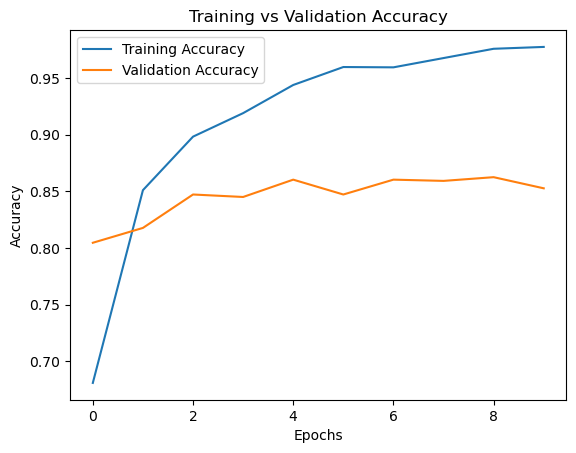

In [40]:

# Plot the training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


#### please  note that this model can be improved to get a better accuracy. The model is  straightforward. For better performance increase the following 


In [73]:
test_generator.class_indices

{'Healthy': 0, 'Osteoporosis': 1}

In [56]:

# Get predictions for the test data
predictions = model.predict(test_generator)

predictions_binary = (predictions > 0.5)

true_labels = test_generator.classes

# Print the classification report
print(classification_report(true_labels, predictions_binary))


29/29 ━━━━━━━━━━━━━━━━━━━━ 8s 261ms/step
              precision    recall  f1-score   support

           0       0.85      0.84      0.85       446
           1       0.85      0.86      0.86       470

    accuracy                           0.85       916
   macro avg       0.85      0.85      0.85       916
weighted avg       0.85      0.85      0.85       916



## Saving and loading the model

In [ ]:
# Save the model
model.save('cnn_model.h5')


In [58]:
model.save('cnn_model.keras')


In [59]:

# Load the model
cnn_model = load_model('cnn_model.keras')

## Testing the loaded cnn model with a healthy knee image path

In [78]:

from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Path to the image
image_path = '/home/jovyan/.cache/kagglehub/datasets/sachinkumar413/osteoporosis-knee-dataset-preprocessed128x256/versions/1/Osteoporosis Knee Dataset/Normal/Normal_75.jpg'
img = load_img(image_path, target_size=(150, 150))  # Resize to (128, 256)
img_array = img_to_array(img)

img_array = img_array / 255.0

img_array = np.expand_dims(img_array, axis=0)






In [79]:
img_array.shape

(1, 150, 150, 3)

In [80]:
predictions = cnn_model.predict(img_array)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


In [81]:
predictions

array([[0.01953134]], dtype=float32)

In [83]:
test_generator.class_indices

{'Healthy': 0, 'Osteoporosis': 1}

## model works very well and  ready for deployment 

# CREATING TRADITIONAL CLASSIFICATION MODEL WITH PATIENT DATA

In [97]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("mohamedgobara/osteoporosis-database")

print("Path to dataset files:", path)

Path to dataset files: /home/jovyan/.cache/kagglehub/datasets/mohamedgobara/osteoporosis-database/versions/1


In [89]:
data = r'/home/jovyan/.cache/kagglehub/datasets/mohamedgobara/osteoporosis-database/versions/1/Osteoporosis Knee X-ray/patient details.xlsx'

['normal', 'osteoporosis', 'patient details.xlsx', 'osteopenia']

In [91]:
data = pd.read_excel(r'/home/jovyan/.cache/kagglehub/datasets/mohamedgobara/osteoporosis-database/versions/1/Osteoporosis Knee X-ray/patient details.xlsx')

In [110]:
data

,S.No,Patient Id,Joint Pain:,Gender,Age,Menopause Age,height (meter),Weight (KG),Smoker,Alcoholic,...,Family History of Osteoporosis,Maximum Walking distance (km),Daily Eating habits,Medical History,T-score Value,Z-Score Value,BMI:,Site,Obesity,Diagnosis
0,1.0,OP1,yes,male,65.000000,NaN,1.645920,65.000000,yes,no,...,no,0.2,normal,normal,-1.98,0.73,23.993627,knee,normal weight,osteopenia
1,2.0,OP2,yes,female,54.000000,46,1.676400,78.000000,no,no,...,no,1.0,normal,"G.B rem, B.P",-2.26,-2.71,27.754876,knee,over weight,osteopenia
2,3.0,OP3,yes,female,49.000000,43,1.371600,59.000000,no,no,...,no,1.0,low protiens,no,-1.92,-1.51,31.361517,knee,obesity,osteopenia
3,4.0,OP4,yes,female,57.000000,40,1.524000,72.000000,no,no,...,no,2.0,low fats,uterus removed,-2.23,-1.13,31.000062,knee,obesity,osteopenia
4,5.0,OP5,yes,female,40.000000,NaN,1.493520,54.000000,no,no,...,no,2.0,normal,depression,-1.81,-1.05,24.208711,knee,normal weight,osteopenia
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
238,239.0,OP154,yes,female,56.000000,48,1.520000,68.000000,no,no,...,yes,0.2,"low fats,proteins","G.B& uterus rem, intestine surgery",-2.01,-1.13,29.432133,knee,overweight,osteopenia
239,240.0,N37,yes,male,39.000000,NaN,1.630000,70.000000,no,no,...,no,5.0,low salt,no,-0.76,-0.59,26.346494,knee,over weight,normal
240,NaN,NaN,NaN,NaN,107.000000,max,1.828800,98.000000,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
241,NaN,NaN,NaN,NaN,17.000000,min,1.371600,39.000000,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [111]:

last_column = data.columns[-1]
df = data[[last_column] + list(data.columns[:-1])]

In [112]:
df
pd.set_option('display.max_columns', None)

In [113]:
# column names normalization

df.columns = df.columns.str.lower().str.replace(' ', '_')

In [114]:
df

,diagnosis,s.no,patient_id,joint_pain:,gender,age,menopause_age,height__(meter),weight_(kg)_,smoker,alcoholic,diabetic,hypothyroidism,number_of_pregnancies,seizer_disorder,estrogen_use,occupation_,history_of_fracture,dialysis:,family_history_of_osteoporosis,maximum_walking_distance_(km),daily_eating_habits,medical_history,t-score_value,z-score_value,bmi:_,site,obesity
0,osteopenia,1.0,OP1,yes,male,65.000000,NaN,1.645920,65.000000,yes,no,no,no,NaN,no,no,shopkeeper,no,no,no,0.2,normal,normal,-1.98,0.73,23.993627,knee,normal weight
1,osteopenia,2.0,OP2,yes,female,54.000000,46,1.676400,78.000000,no,no,no,no,3.0,no,no,h.wife,no,no,no,1.0,normal,"G.B rem, B.P",-2.26,-2.71,27.754876,knee,over weight
2,osteopenia,3.0,OP3,yes,female,49.000000,43,1.371600,59.000000,no,no,no,yes,3.0,no,no,h.wife,l.leg,no,no,1.0,low protiens,no,-1.92,-1.51,31.361517,knee,obesity
3,osteopenia,4.0,OP4,yes,female,57.000000,40,1.524000,72.000000,no,no,no,yes,3.0,no,no,teacher,no,no,no,2.0,low fats,uterus removed,-2.23,-1.13,31.000062,knee,obesity
4,osteopenia,5.0,OP5,yes,female,40.000000,NaN,1.493520,54.000000,no,no,no,no,3.0,no,no,h.wife,no,no,no,2.0,normal,depression,-1.81,-1.05,24.208711,knee,normal weight
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
238,osteopenia,239.0,OP154,yes,female,56.000000,48,1.520000,68.000000,no,no,no,no,6.0,no,no,h.wife,no,no,yes,0.2,"low fats,proteins","G.B& uterus rem, intestine surgery",-2.01,-1.13,29.432133,knee,overweight
239,normal,240.0,N37,yes,male,39.000000,NaN,1.630000,70.000000,no,no,no,no,NaN,no,no,bussinesman,knee fracture,no,no,5.0,low salt,no,-0.76,-0.59,26.346494,knee,over weight
240,NaN,NaN,NaN,NaN,NaN,107.000000,max,1.828800,98.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
241,NaN,NaN,NaN,NaN,NaN,17.000000,min,1.371600,39.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [115]:
df.columns

Index(['diagnosis', 's.no', 'patient_id', 'joint_pain:', 'gender', 'age',
       'menopause_age', 'height__(meter)', 'weight_(kg)_', 'smoker',
       'alcoholic', 'diabetic', 'hypothyroidism', 'number_of_pregnancies',
       'seizer_disorder', 'estrogen_use', 'occupation_', 'history_of_fracture',
       'dialysis:', 'family_history_of_osteoporosis',
       'maximum_walking_distance_(km)', 'daily_eating_habits',
       'medical_history', 't-score_value', 'z-score_value', 'bmi:_', 'site',
       'obesity'],
      dtype='object')

In [116]:
df['diagnosis'] = df['diagnosis'].replace({'osteopenia':'osteoporosis'})

In [117]:
df['diagnosis']=df['diagnosis'].map({'osteoporosis':1,'normal':0})

In [178]:
df.head()

,diagnosis,joint_pain:,gender,age,menopause_age,height__(meter),weight_(kg)_,smoker,diabetic,hypothyroidism,number_of_pregnancies,seizer_disorder,estrogen_use,history_of_fracture,dialysis:,family_history_of_osteoporosis,maximum_walking_distance_(km),medical_history,t-score_value,z-score_value,bmi:_,obesity
0,osteoporosis,1.0,1.0,65.0,45.066265,1.64592,65.0,1.0,0.0,0.0,3.443548,0.0,0.0,0,0.0,0.0,0.2,1,-1.98,0.73,23.993627,0
1,osteoporosis,1.0,0.0,54.0,46.000000,1.67640,78.0,0.0,0.0,0.0,3.000000,0.0,0.0,0,0.0,0.0,1.0,1,-2.26,-2.71,27.754876,1
2,osteoporosis,1.0,0.0,49.0,43.000000,1.37160,59.0,0.0,0.0,1.0,3.000000,0.0,0.0,1,0.0,0.0,1.0,0,-1.92,-1.51,31.361517,1
3,osteoporosis,1.0,0.0,57.0,40.000000,1.52400,72.0,0.0,0.0,1.0,3.000000,0.0,0.0,0,0.0,0.0,2.0,1,-2.23,-1.13,31.000062,1
4,osteoporosis,1.0,0.0,40.0,45.066265,1.49352,54.0,0.0,0.0,0.0,3.000000,0.0,0.0,0,0.0,0.0,2.0,1,-1.81,-1.05,24.208711,0


In [119]:
df.drop(['s.no', 'patient_id','daily_eating_habits','site','occupation_','alcoholic'], axis = 1, inplace = True)

## Feature engineerig and Visualization section 

In [120]:
# Replace all values in 'medical_history' column with 'yes', except for 'no'
df['medical_history'] = df['medical_history'].apply(lambda x: 'yes' if x != 'no' else 'no')

# Check the transformation
print(df['medical_history'].value_counts())


medical_history
yes    130
no     113
Name: count, dtype: int64


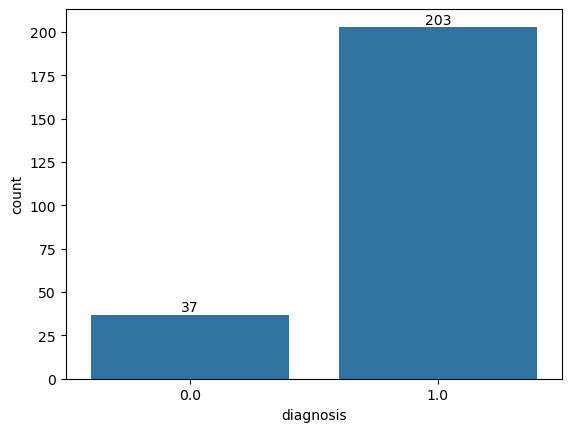

In [125]:
# check the independent varible

target_check = sns.countplot(data=df, x='diagnosis')

# Adding  data labels to have idea of the distribution
for p in target_check.patches:
    target_check.annotate(
        f'{int(p.get_height())}',
        (p.get_x() + p.get_width() / 2, p.get_height()), 
        ha='center',  
        va='bottom' 
    )

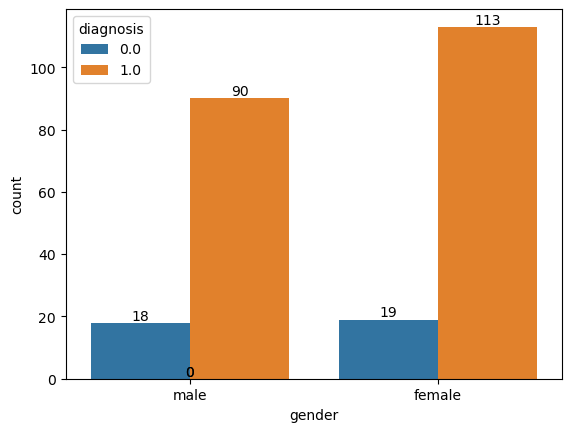

In [126]:
# observing the relationship between gender and my target variable

gender_target = sns.countplot(data = df,x = 'gender',hue = 'diagnosis')

# Adding a  data labels to have idea of our  target count in each feature
for p in gender_target.patches:
    gender_target.annotate(
        f'{int(p.get_height())}',
        (p.get_x() + p.get_width() / 2, p.get_height()), 
        ha='center',  
        va='bottom' 
    )

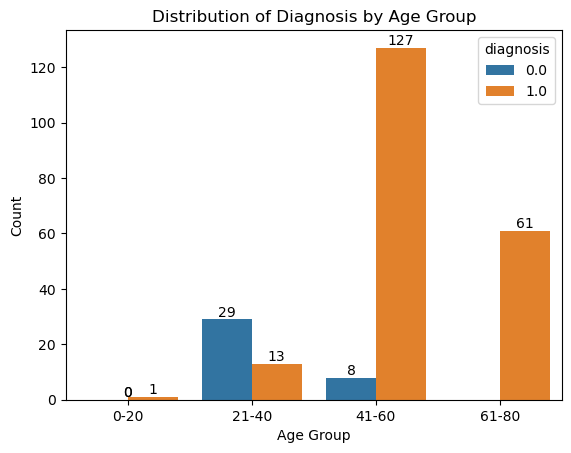

In [127]:

# Create age bins and labels
age_bins = [0, 20, 40, 60, 80]  # Adjust these ranges as per your data
age_labels = ['0-20', '21-40', '41-60', '61-80']
df['age_bin'] = pd.cut(df['age'], bins=age_bins, labels=age_labels, right=False)

# Create a count plot with 'age_bin' and 'diagnosis'
age_target = sns.countplot(data=df, x='age_bin', hue='diagnosis')

# Adding data labels to show the count in each bin for each hue
for p in age_target.patches:
    age_target.annotate(
        f'{int(p.get_height())}',
        (p.get_x() + p.get_width() / 2, p.get_height()),
        ha='center',
        va='bottom'
    )

# Set labels and title
plt.xlabel('Age Group')
plt.ylabel('Count')
plt.title('Distribution of Diagnosis by Age Group')

# Show the plot
plt.show()


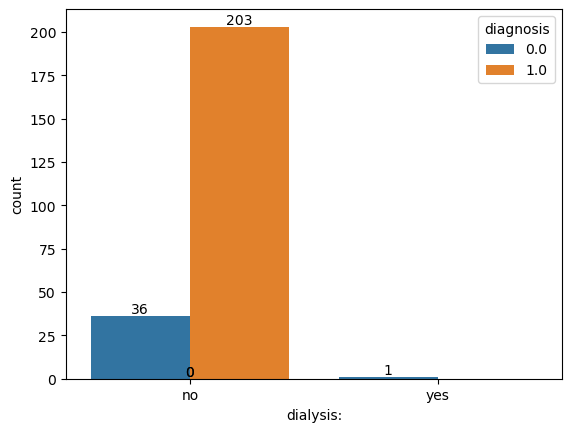

In [128]:
# checking dialysis feature

vis = sns.countplot(data = df,x = 'dialysis:',hue = 'diagnosis')

# Adding a  data labels to have idea of our  target count in each feature
for p in vis.patches:
    vis.annotate(
        f'{int(p.get_height())}',
        (p.get_x() + p.get_width() / 2, p.get_height()), 
        ha='center',  
        va='bottom' 
    )

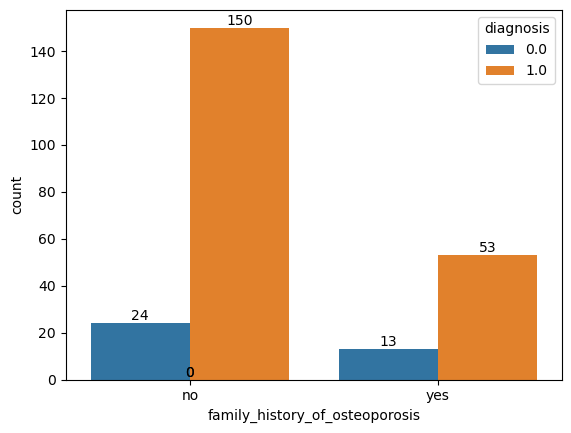

In [129]:
vis = sns.countplot(data = df,x = 'family_history_of_osteoporosis',hue = 'diagnosis')

# Adding a  data labels to have idea of our  target count in each feature
for p in vis.patches:
    vis.annotate(
        f'{int(p.get_height())}',
        (p.get_x() + p.get_width() / 2, p.get_height()), 
        ha='center',  
        va='bottom' 
    )

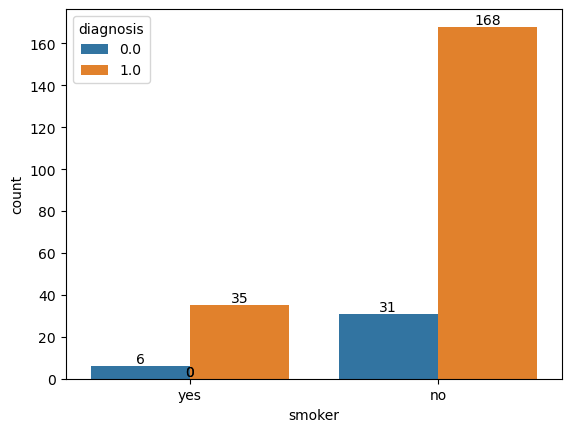

In [130]:
vis = sns.countplot(data = df,x = 'smoker',hue = 'diagnosis')

# Adding a  data labels to have idea of our  target count in each feature
for p in vis.patches:
    vis.annotate(
        f'{int(p.get_height())}',
        (p.get_x() + p.get_width() / 2, p.get_height()), 
        ha='center',  
        va='bottom' 
    )

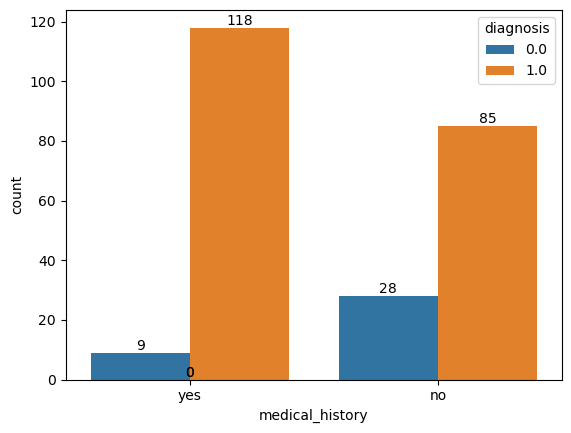

In [131]:
vis = sns.countplot(data = df,x = 'medical_history',hue = 'diagnosis')

# Adding a  data labels to have idea of our  target count in each feature
for p in vis.patches:
    vis.annotate(
        f'{int(p.get_height())}',
        (p.get_x() + p.get_width() / 2, p.get_height()), 
        ha='center',  
        va='bottom' 
    )

In [132]:
df['diabetic'].value_counts()

diabetic
no     228
yes     12
Name: count, dtype: int64

In [133]:
df

,diagnosis,joint_pain:,gender,age,menopause_age,height__(meter),weight_(kg)_,smoker,diabetic,hypothyroidism,number_of_pregnancies,seizer_disorder,estrogen_use,history_of_fracture,dialysis:,family_history_of_osteoporosis,maximum_walking_distance_(km),medical_history,t-score_value,z-score_value,bmi:_,obesity,age_bin
0,1.0,yes,male,65.000000,NaN,1.645920,65.000000,yes,no,no,NaN,no,no,no,no,no,0.2,yes,-1.98,0.73,23.993627,normal weight,61-80
1,1.0,yes,female,54.000000,46,1.676400,78.000000,no,no,no,3.0,no,no,no,no,no,1.0,yes,-2.26,-2.71,27.754876,over weight,41-60
2,1.0,yes,female,49.000000,43,1.371600,59.000000,no,no,yes,3.0,no,no,l.leg,no,no,1.0,no,-1.92,-1.51,31.361517,obesity,41-60
3,1.0,yes,female,57.000000,40,1.524000,72.000000,no,no,yes,3.0,no,no,no,no,no,2.0,yes,-2.23,-1.13,31.000062,obesity,41-60
4,1.0,yes,female,40.000000,NaN,1.493520,54.000000,no,no,no,3.0,no,no,no,no,no,2.0,yes,-1.81,-1.05,24.208711,normal weight,41-60
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
238,1.0,yes,female,56.000000,48,1.520000,68.000000,no,no,no,6.0,no,no,no,no,yes,0.2,yes,-2.01,-1.13,29.432133,overweight,41-60
239,0.0,yes,male,39.000000,NaN,1.630000,70.000000,no,no,no,NaN,no,no,knee fracture,no,no,5.0,no,-0.76,-0.59,26.346494,over weight,21-40
240,NaN,NaN,NaN,107.000000,max,1.828800,98.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,yes,NaN,NaN,NaN,NaN,NaN
241,NaN,NaN,NaN,17.000000,min,1.371600,39.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,yes,NaN,NaN,NaN,NaN,0-20


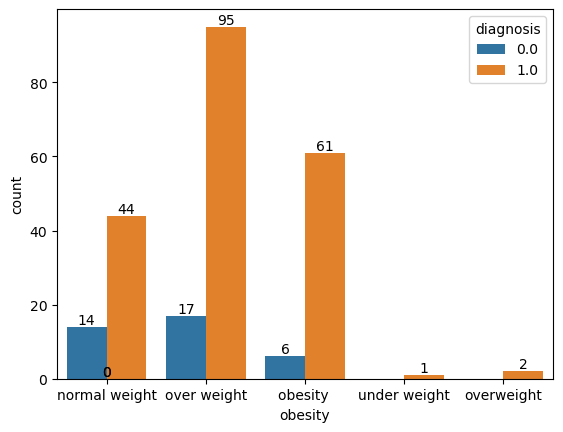

In [134]:
vis = sns.countplot(data = df,x = 'obesity',hue = 'diagnosis')

# Adding a  data labels to have idea of our  target count in each feature
for p in vis.patches:
    vis.annotate(
        f'{int(p.get_height())}',
        (p.get_x() + p.get_width() / 2, p.get_height()), 
        ha='center',  
        va='bottom' 
    )

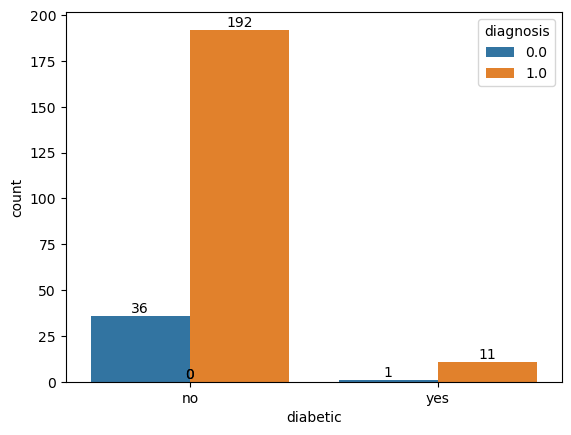

In [135]:
vis = sns.countplot(data = df,x = 'diabetic',hue = 'diagnosis')

# Adding a  data labels to have idea of our  target count in each feature
for p in vis.patches:
    vis.annotate(
        f'{int(p.get_height())}',
        (p.get_x() + p.get_width() / 2, p.get_height()), 
        ha='center',  
        va='bottom' 
    )

In [136]:
df['history_of_fracture'] = df['history_of_fracture'].apply(lambda x: 'yes' if x != 'no' else 'no')

# Check the transformation
print(df['history_of_fracture'].value_counts())

history_of_fracture
no     169
yes     74
Name: count, dtype: int64


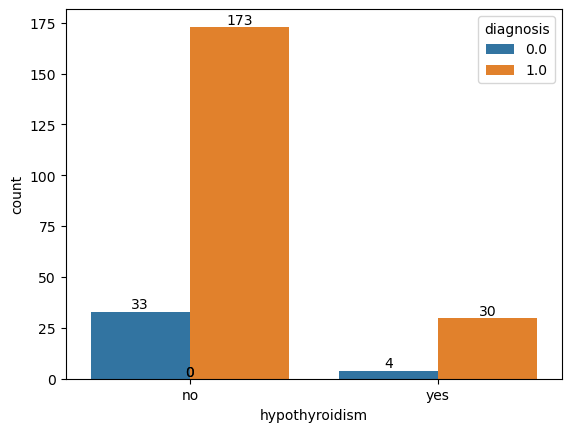

In [137]:
vis = sns.countplot(data = df,x = 'hypothyroidism',hue = 'diagnosis')

# Adding a  data labels to have idea of our  target count in each feature
for p in vis.patches:
    vis.annotate(
        f'{int(p.get_height())}',
        (p.get_x() + p.get_width() / 2, p.get_height()), 
        ha='center',  
        va='bottom' 
    )

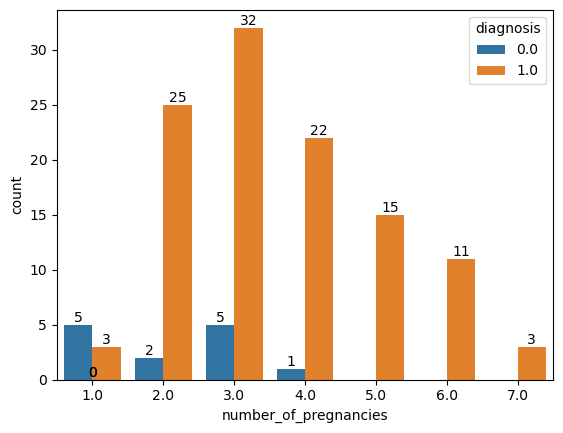

In [138]:
vis = sns.countplot(data = df,x = 'number_of_pregnancies',hue = 'diagnosis')

# Adding a  data labels to have idea of our  target count in each feature
for p in vis.patches:
    vis.annotate(
        f'{int(p.get_height())}',
        (p.get_x() + p.get_width() / 2, p.get_height()), 
        ha='center',  
        va='bottom' 
    )

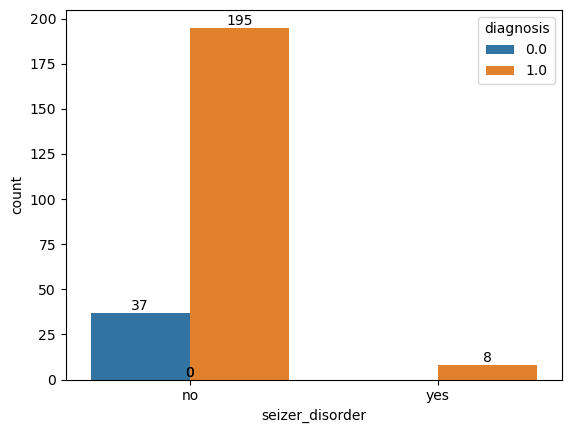

In [139]:
vis = sns.countplot(data = df,x = 'seizer_disorder',hue = 'diagnosis')

# Adding a  data labels to have idea of our  target count in each feature
for p in vis.patches:
    vis.annotate(
        f'{int(p.get_height())}',
        (p.get_x() + p.get_width() / 2, p.get_height()), 
        ha='center',  
        va='bottom' 
    )

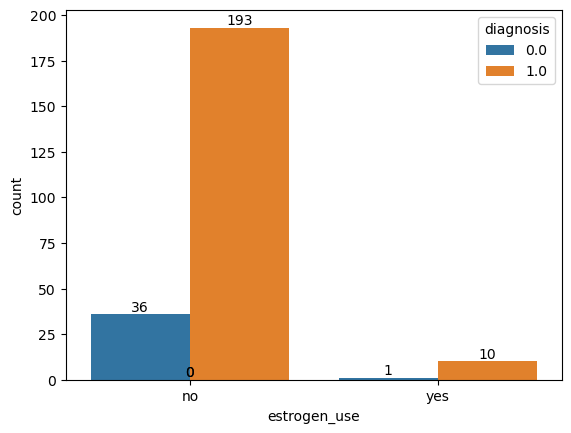

In [140]:
vis = sns.countplot(data = df,x = 'estrogen_use',hue = 'diagnosis')

# Adding a  data labels to have idea of our  target count in each feature
for p in vis.patches:
    vis.annotate(
        f'{int(p.get_height())}',
        (p.get_x() + p.get_width() / 2, p.get_height()), 
        ha='center',  
        va='bottom' 
    )

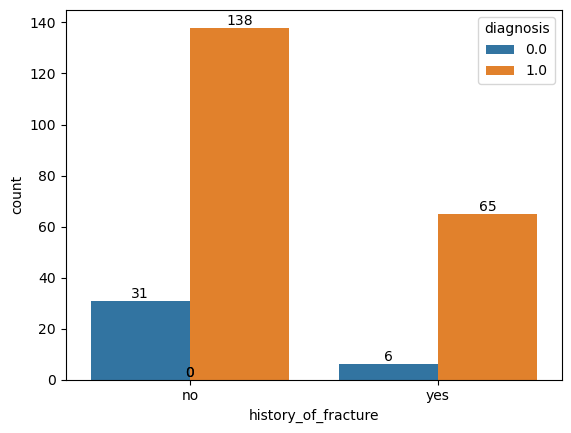

In [141]:
vis = sns.countplot(data = df,x = 'history_of_fracture',hue = 'diagnosis')

# Adding a  data labels to have idea of our  target count in each feature
for p in vis.patches:
    vis.annotate(
        f'{int(p.get_height())}',
        (p.get_x() + p.get_width() / 2, p.get_height()), 
        ha='center',  
        va='bottom' 
    )

In [142]:
df = df.drop(['age_bin'],axis = 1)

In [143]:


# Assuming df is your DataFrame and 'obesity' is one of the columns
df['obesity'] = df['obesity'].apply(lambda x: 'no' if x == 'normal weight' else 'yes')

# Check the transformation
print(df['obesity'].value_counts())



obesity
yes    185
no      58
Name: count, dtype: int64


In [144]:
# Mapping "Yes" to 1 and "No" to 0 in the relevant columns
df['joint_pain:'] = df['joint_pain:'].map({'yes': 1, 'no': 0})
df['smoker'] = df['smoker'].map({'yes': 1, 'no': 0})
df['diabetic'] = df['diabetic'].map({'yes': 1, 'no': 0})
df['hypothyroidism'] = df['hypothyroidism'].map({'yes': 1, 'no': 0})
df['seizer_disorder'] = df['seizer_disorder'].map({'yes': 1, 'no': 0})
df['dialysis:'] = df['dialysis:'].map({'yes': 1, 'no': 0})
df['family_history_of_osteoporosis'] = df['family_history_of_osteoporosis'].map({'yes': 1, 'no': 0})
df['estrogen_use'] = df['estrogen_use'].map({'yes': 1, 'no': 0})
df['history_of_fracture'] = df['history_of_fracture'].map({'yes': 1, 'no': 0})
df['medical_history'] = df['medical_history'].map({'yes': 1, 'no': 0})
df['obesity'] = df['obesity'].map({'yes': 1, 'no': 0})

# Mapping "Male" to 1 and "Female" to 0 in the relevant column
df['gender'] = df['gender'].map({'male': 1, 'female': 0})


In [145]:


# Remove rows where 'menopause_age' is 'max', 'avg', or 'min'
df = df[~df['menopause_age'].isin(['max', 'avg', 'min'])]



In [146]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 240 entries, 0 to 239
Data columns (total 22 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   diagnosis                       240 non-null    float64
 1   joint_pain:                     240 non-null    float64
 2   gender                          240 non-null    float64
 3   age                             240 non-null    float64
 4   menopause_age                   83 non-null     object 
 5   height__(meter)                 240 non-null    float64
 6   weight_(kg)_                    240 non-null    float64
 7   smoker                          240 non-null    float64
 8   diabetic                        240 non-null    float64
 9   hypothyroidism                  240 non-null    float64
 10  number_of_pregnancies           124 non-null    float64
 11  seizer_disorder                 240 non-null    float64
 12  estrogen_use                    240 non-n

In [147]:
df.head()

,diagnosis,joint_pain:,gender,age,menopause_age,height__(meter),weight_(kg)_,smoker,diabetic,hypothyroidism,number_of_pregnancies,seizer_disorder,estrogen_use,history_of_fracture,dialysis:,family_history_of_osteoporosis,maximum_walking_distance_(km),medical_history,t-score_value,z-score_value,bmi:_,obesity
0,1.0,1.0,1.0,65.0,NaN,1.64592,65.0,1.0,0.0,0.0,NaN,0.0,0.0,0,0.0,0.0,0.2,1,-1.98,0.73,23.993627,0
1,1.0,1.0,0.0,54.0,46,1.67640,78.0,0.0,0.0,0.0,3.0,0.0,0.0,0,0.0,0.0,1.0,1,-2.26,-2.71,27.754876,1
2,1.0,1.0,0.0,49.0,43,1.37160,59.0,0.0,0.0,1.0,3.0,0.0,0.0,1,0.0,0.0,1.0,0,-1.92,-1.51,31.361517,1
3,1.0,1.0,0.0,57.0,40,1.52400,72.0,0.0,0.0,1.0,3.0,0.0,0.0,0,0.0,0.0,2.0,1,-2.23,-1.13,31.000062,1
4,1.0,1.0,0.0,40.0,NaN,1.49352,54.0,0.0,0.0,0.0,3.0,0.0,0.0,0,0.0,0.0,2.0,1,-1.81,-1.05,24.208711,0


In [148]:
correlation = df.corr()
correlation

,diagnosis,joint_pain:,gender,age,menopause_age,height__(meter),weight_(kg)_,smoker,diabetic,hypothyroidism,number_of_pregnancies,seizer_disorder,estrogen_use,history_of_fracture,dialysis:,family_history_of_osteoporosis,maximum_walking_distance_(km),medical_history,t-score_value,z-score_value,bmi:_,obesity
diagnosis,1.000000,-0.039136,-0.031311,0.564020,0.081763,-0.067806,0.095596,0.009836,0.045001,0.041086,0.302142,0.079278,0.038393,0.125034,-0.151512,-0.073002,-0.061202,0.244553,-0.738673,-0.390022,0.143844,0.136339
joint_pain:,-0.039136,1.000000,-0.009213,0.047640,NaN,-0.089897,-0.109776,0.041609,0.021031,0.037242,0.027378,0.017023,0.020091,0.059417,0.005930,-0.046193,-0.032816,0.005357,0.023575,0.093463,-0.020478,-0.051749
gender,-0.031311,-0.009213,1.000000,0.338484,NaN,0.631198,0.127718,0.501811,0.023057,-0.103278,0.034347,-0.167968,-0.198246,-0.054133,0.071512,-0.069401,0.383161,-0.203867,-0.037351,-0.103711,-0.405988,-0.311071
age,0.564020,0.047640,0.338484,1.000000,0.541853,0.061880,0.028611,0.268183,0.140322,-0.066935,0.354044,-0.087289,-0.092544,0.124477,-0.066996,-0.131149,0.004111,0.083623,-0.744357,-0.238454,-0.031458,-0.108446
menopause_age,0.081763,NaN,NaN,0.541853,1.000000,-0.268661,-0.244080,NaN,0.078736,-0.221335,0.151636,-0.212012,-0.230149,-0.040675,NaN,0.210006,-0.034929,-0.194034,-0.531470,-0.209114,-0.048642,-0.231019
height__(meter),-0.067806,-0.089897,0.631198,0.061880,-0.268661,1.000000,0.389600,0.166161,0.012354,-0.008382,-0.251909,-0.066864,-0.093250,-0.080251,0.082029,0.004944,0.263201,-0.094063,0.051287,-0.018469,-0.462676,-0.267466
weight_(kg)_,0.095596,-0.109776,0.127718,0.028611,-0.244080,0.389600,1.000000,-0.012041,0.084640,0.052546,0.030765,0.086326,-0.007594,-0.010646,0.101156,0.040190,-0.050399,0.079148,-0.058043,-0.116536,0.629992,0.496493
smoker,0.009836,0.041609,0.501811,0.268183,NaN,0.166161,-0.012041,1.000000,0.048257,-0.057411,NaN,-0.084288,-0.099482,-0.003133,-0.029361,-0.105994,0.138258,-0.081972,-0.052970,-0.005105,-0.162879,-0.157536
diabetic,0.045001,0.021031,0.023057,0.140322,0.078736,0.012354,0.084640,0.048257,1.000000,-0.038378,0.163078,-0.042601,-0.050281,0.060736,-0.014840,-0.055661,-0.056716,0.101498,-0.114754,-0.041452,0.073586,-0.004466
hypothyroidism,0.041086,0.037242,-0.103278,-0.066935,-0.221335,-0.008382,0.052546,-0.057411,-0.038378,1.000000,-0.227721,0.057690,0.025236,0.024653,-0.026279,-0.009366,-0.037769,0.191708,0.078809,0.062496,0.051550,0.089783


# Evidently i'm going to arrive at a good accuracy, most of my features are correlated 

In [149]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 240 entries, 0 to 239
Data columns (total 22 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   diagnosis                       240 non-null    float64
 1   joint_pain:                     240 non-null    float64
 2   gender                          240 non-null    float64
 3   age                             240 non-null    float64
 4   menopause_age                   83 non-null     object 
 5   height__(meter)                 240 non-null    float64
 6   weight_(kg)_                    240 non-null    float64
 7   smoker                          240 non-null    float64
 8   diabetic                        240 non-null    float64
 9   hypothyroidism                  240 non-null    float64
 10  number_of_pregnancies           124 non-null    float64
 11  seizer_disorder                 240 non-null    float64
 12  estrogen_use                    240 non-n

In [150]:
df['menopause_age'] = pd.to_numeric(df['menopause_age'], errors='coerce')


In [151]:
df.isna().sum()

diagnosis                           0
joint_pain:                         0
gender                              0
age                                 0
menopause_age                     157
height__(meter)                     0
weight_(kg)_                        0
smoker                              0
diabetic                            0
hypothyroidism                      0
number_of_pregnancies             116
seizer_disorder                     0
estrogen_use                        0
history_of_fracture                 0
dialysis:                           0
family_history_of_osteoporosis      0
maximum_walking_distance_(km)       1
medical_history                     0
t-score_value                       0
z-score_value                       0
bmi:_                               0
obesity                             0
dtype: int64

In [152]:


# Fill missing values (NaN) with the mean
df['menopause_age'] = df['menopause_age'].fillna(df['menopause_age'].mean())
df['number_of_pregnancies'] = df['number_of_pregnancies'].fillna(df['number_of_pregnancies'].mean())
df['maximum_walking_distance_(km)'] = df['maximum_walking_distance_(km)'].fillna(df['maximum_walking_distance_(km)'].mean())


In [153]:
df.isna().sum()

diagnosis                         0
joint_pain:                       0
gender                            0
age                               0
menopause_age                     0
height__(meter)                   0
weight_(kg)_                      0
smoker                            0
diabetic                          0
hypothyroidism                    0
number_of_pregnancies             0
seizer_disorder                   0
estrogen_use                      0
history_of_fracture               0
dialysis:                         0
family_history_of_osteoporosis    0
maximum_walking_distance_(km)     0
medical_history                   0
t-score_value                     0
z-score_value                     0
bmi:_                             0
obesity                           0
dtype: int64

In [154]:
corr = df.corr()

<Axes: >

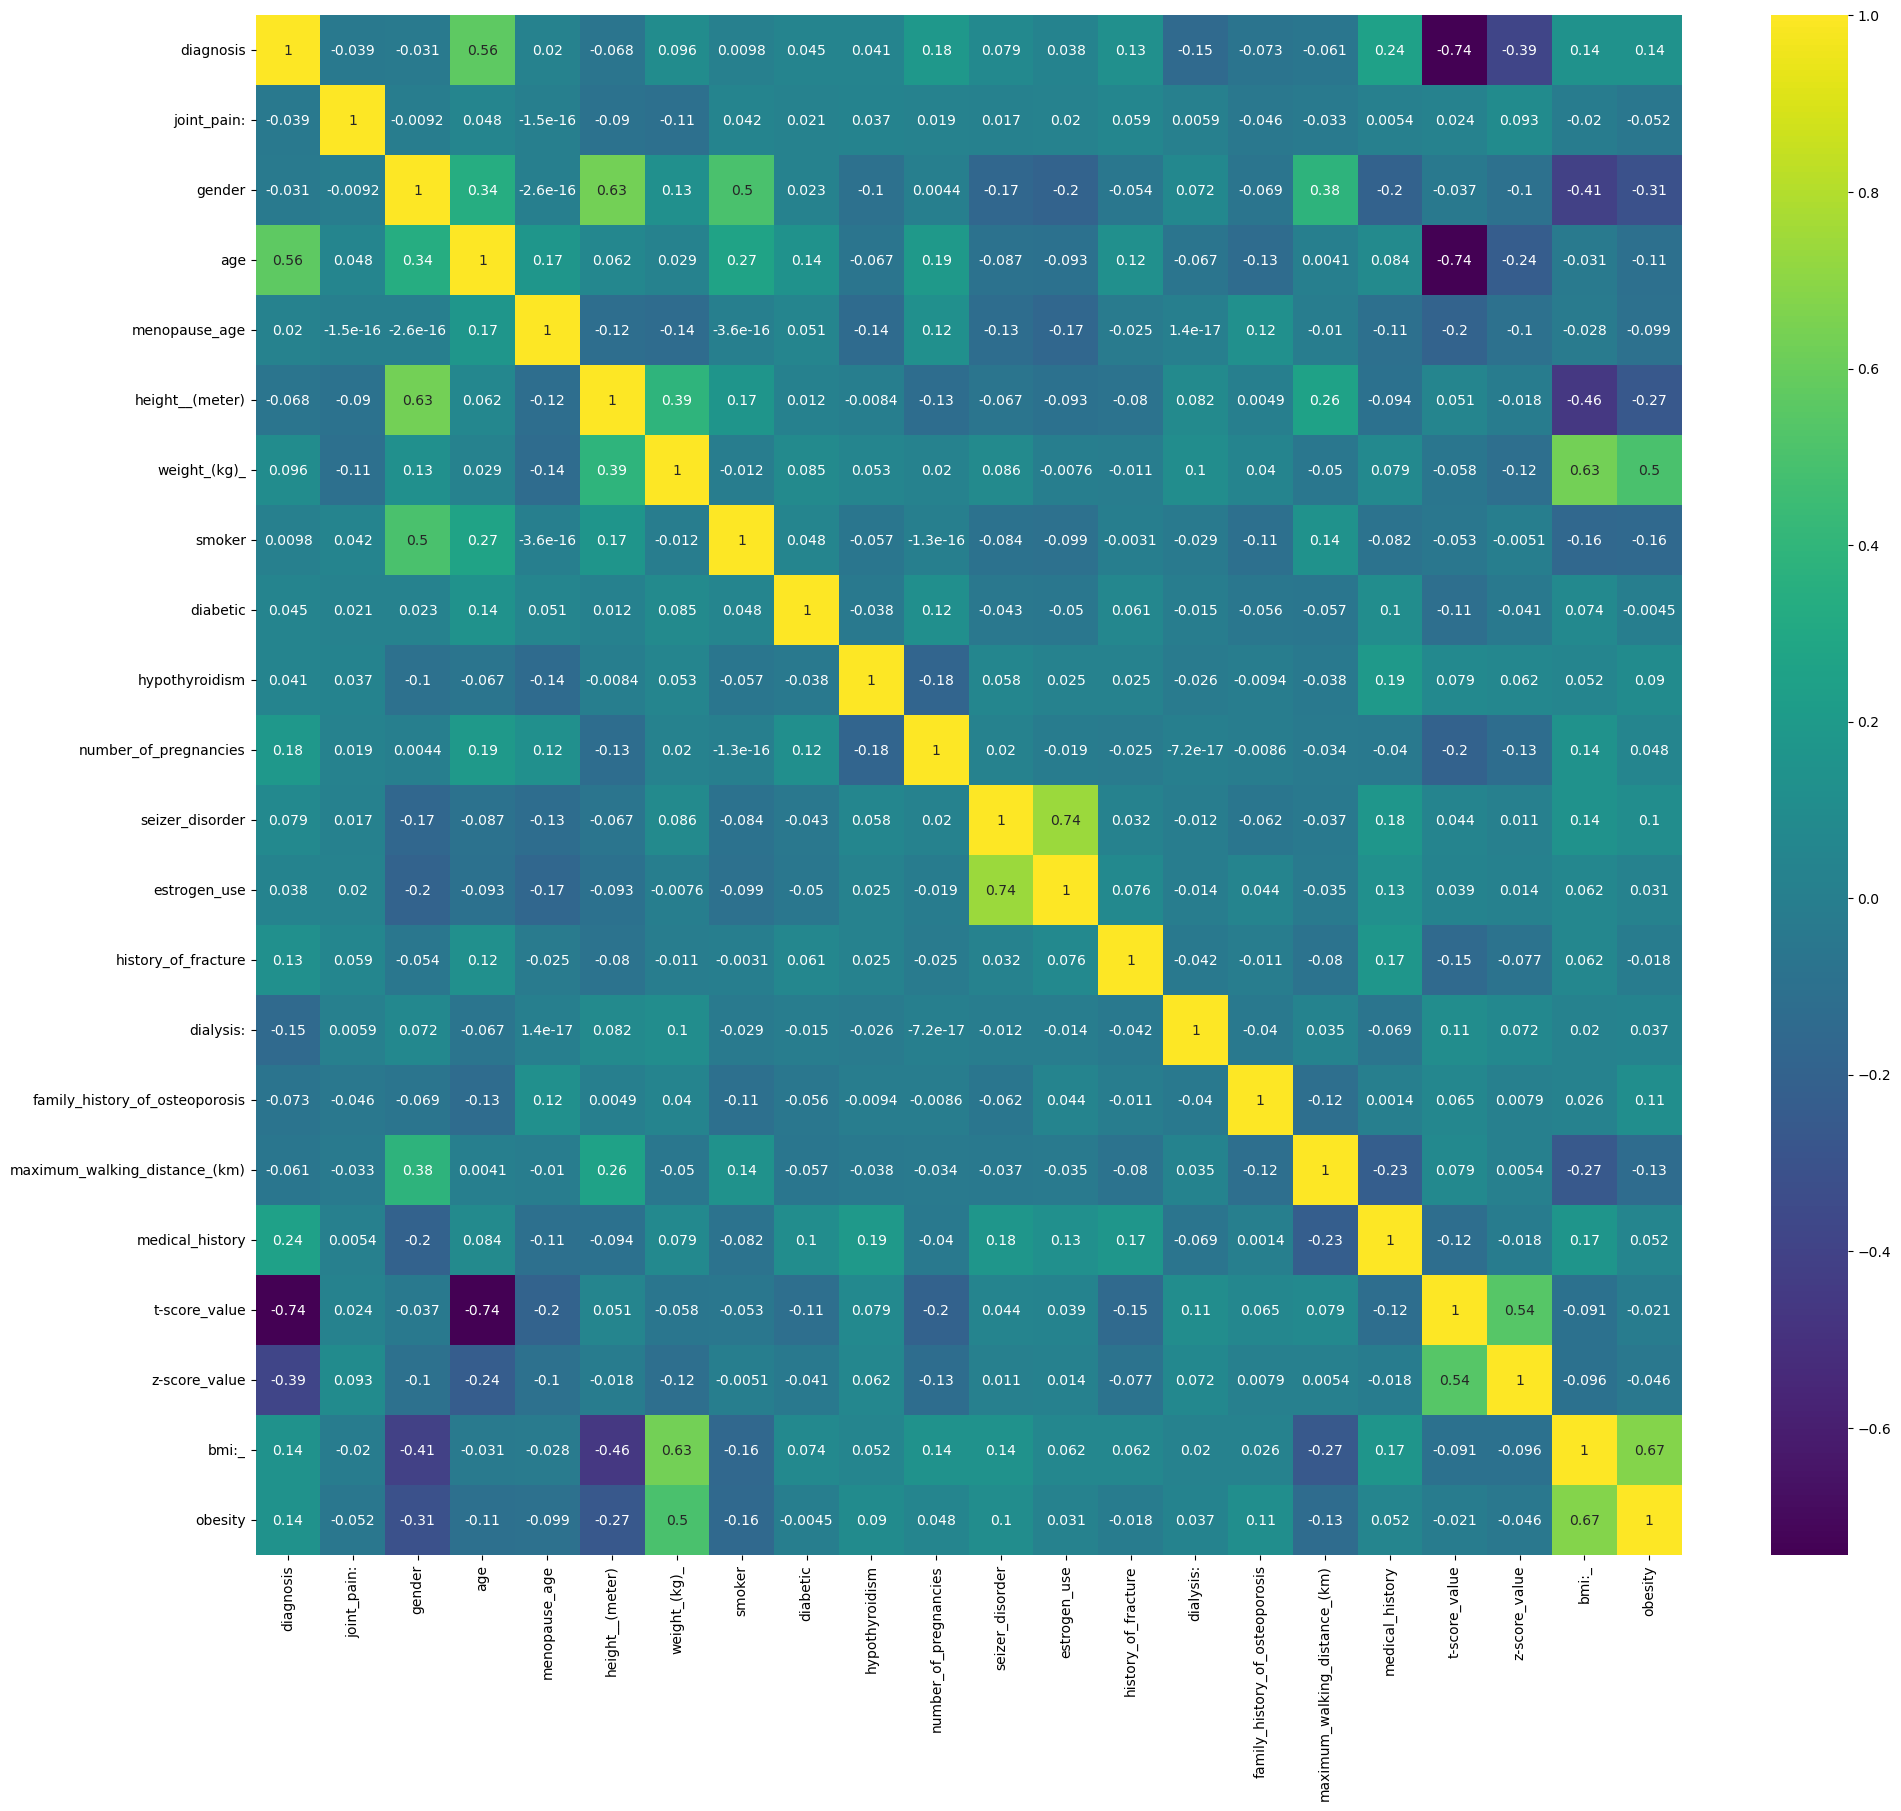

In [155]:
plt.figure(figsize=(23,20))

sns.heatmap(corr,annot = True,cmap= 'viridis')

<Axes: >

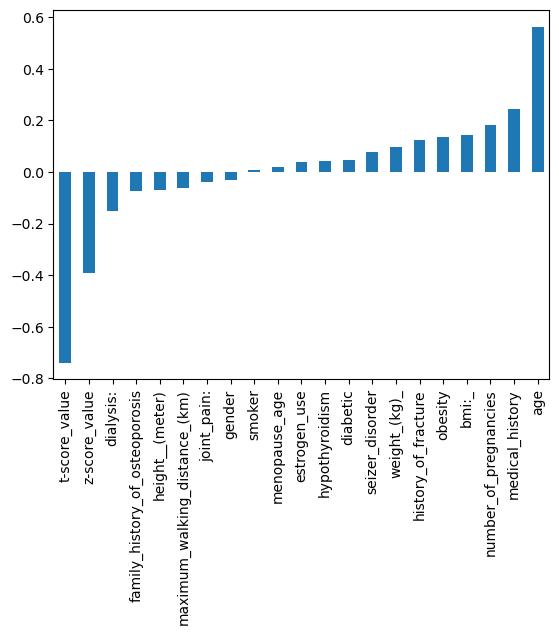

In [156]:

df.corr()['diagnosis'].sort_values().drop('diagnosis').plot(kind ='bar')

In [157]:
df['diagnosis'] = df['diagnosis'].map({1.0:'osteoporosis',0.0:'normal'})

In [158]:
df

,diagnosis,joint_pain:,gender,age,menopause_age,height__(meter),weight_(kg)_,smoker,diabetic,hypothyroidism,number_of_pregnancies,seizer_disorder,estrogen_use,history_of_fracture,dialysis:,family_history_of_osteoporosis,maximum_walking_distance_(km),medical_history,t-score_value,z-score_value,bmi:_,obesity
0,osteoporosis,1.0,1.0,65.0,45.066265,1.64592,65.0,1.0,0.0,0.0,3.443548,0.0,0.0,0,0.0,0.0,0.2,1,-1.98,0.73,23.993627,0
1,osteoporosis,1.0,0.0,54.0,46.000000,1.67640,78.0,0.0,0.0,0.0,3.000000,0.0,0.0,0,0.0,0.0,1.0,1,-2.26,-2.71,27.754876,1
2,osteoporosis,1.0,0.0,49.0,43.000000,1.37160,59.0,0.0,0.0,1.0,3.000000,0.0,0.0,1,0.0,0.0,1.0,0,-1.92,-1.51,31.361517,1
3,osteoporosis,1.0,0.0,57.0,40.000000,1.52400,72.0,0.0,0.0,1.0,3.000000,0.0,0.0,0,0.0,0.0,2.0,1,-2.23,-1.13,31.000062,1
4,osteoporosis,1.0,0.0,40.0,45.066265,1.49352,54.0,0.0,0.0,0.0,3.000000,0.0,0.0,0,0.0,0.0,2.0,1,-1.81,-1.05,24.208711,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
235,osteoporosis,1.0,0.0,56.0,45.066265,1.54000,80.0,0.0,0.0,1.0,5.000000,1.0,1.0,0,0.0,1.0,0.2,1,-1.97,-1.34,33.732501,1
236,osteoporosis,1.0,1.0,55.0,45.066265,1.53000,63.0,0.0,0.0,0.0,3.443548,0.0,0.0,0,0.0,0.0,6.0,1,-2.99,-2.42,26.912726,1
237,osteoporosis,1.0,1.0,49.0,45.066265,1.67000,88.0,0.0,0.0,0.0,3.443548,0.0,0.0,1,0.0,1.0,0.5,1,-1.72,-1.21,31.553659,1
238,osteoporosis,1.0,0.0,56.0,48.000000,1.52000,68.0,0.0,0.0,0.0,6.000000,0.0,0.0,0,0.0,1.0,0.2,1,-2.01,-1.13,29.432133,1


In [159]:
X = df.drop(['diagnosis'],axis = 1)
y = df['diagnosis']

In [160]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

In [164]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaler.fit(X_train)

MinMaxScaler()

In [165]:
x_train_scaled= scaler.transform(X_train)
x_test_scaled = scaler.transform(X_test)

# model creation 

In [166]:
from sklearn.linear_model import LogisticRegression

lgr = LogisticRegression()

# Fit the model


lgr.fit(x_train_scaled, y_train)

# Evaluate the model

y_pred_lgr = lgr.predict(x_test_scaled)

print(classification_report(y_test,y_pred_lgr))

              precision    recall  f1-score   support

      normal       1.00      0.70      0.82        10
osteoporosis       0.95      1.00      0.98        62

    accuracy                           0.96        72
   macro avg       0.98      0.85      0.90        72
weighted avg       0.96      0.96      0.96        72



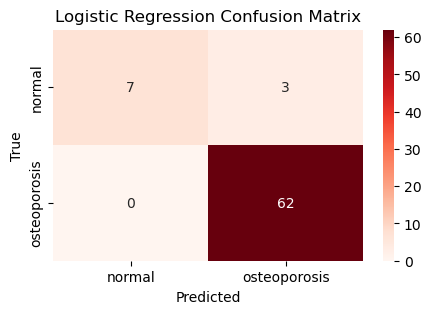

In [167]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test,y_pred_lgr)

cm = confusion_matrix(y_test, y_pred_lgr)
cm = cm.reshape((2, 2))

# Create heatmap
plt.figure(figsize=(5, 3))
sns.heatmap(cm, annot=True, fmt='d', cmap='Reds', xticklabels=['normal', 'osteoporosis'], yticklabels=['normal', 'osteoporosis'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Logistic Regression Confusion Matrix')
plt.show()

In [171]:
cv_scores_lgr = cross_val_score(lgr, x_train_scaled, y_train, cv=5)
print("Cross-validation accuracy: {:.2f} %".format(cv_scores_lgr.mean()*100))

Cross-validation accuracy: 90.50 %


In [627]:
from imblearn.under_sampling import TomekLinks,NearMiss
from imblearn.over_sampling import RandomOverSampler,SMOTE
from imblearn.combine import SMOTETomek

def sampler_function(data_x, data_y, sampler = 0, random_state = 42):
    
    if sampler == 0:
        sampler = RandomOverSampler(random_state = random_state)
    elif sampler == 1:
        sampler = TomekLinks()
    elif sampler == 2:
        sampler = SMOTE()
    elif sampler == 3:
        sampler = SMOTETomek()
    else: 
        sampler = NearMiss()
    X_transformed, y_transformed = sampler.fit_resample(data_x, data_y)
    
    print('Original dataset shape:', data_y.shape)
    print('Resample dataset shape:', y_transformed.shape)
    
    return X_transformed, y_transformed

In [628]:
X_train_res, y_train_res = sampler_function(x_train_scaled, y_train,sampler =2)

Original dataset shape: (168,)
Resample dataset shape: (282,)


In [629]:
from sklearn.linear_model import LogisticRegression

lgr = LogisticRegression()

# Fit the model


lgr.fit(X_train_res, y_train_res)

# Evaluate the model

y_pred_lgrc = lgr.predict(x_test_scaled)

print(classification_report(y_test,y_pred_lgrc))

              precision    recall  f1-score   support

      normal       0.67      1.00      0.80        10
osteoporosis       1.00      0.92      0.96        62

    accuracy                           0.93        72
   macro avg       0.83      0.96      0.88        72
weighted avg       0.95      0.93      0.94        72



## WOW!!! Wwithout resampling model performs  better 

In [99]:
import joblib

## saving and loading the model  and scaler

In [132]:
joblib.dump(lgr, 'Logistic_knee_models.pk1')

['Logistic_knee_models.pk1']

In [100]:
model_log = joblib.load( 'Logistic_knee_models.pk1')

In [101]:
model_log

LogisticRegression()

In [ ]:
knee_osteoporosis_df

In [102]:
knee_scaler = joblib.load('Knee_scaler')

In [ ]:
joblib.dump(scaler,'Knee_scaler.pk1')

In [ ]:
knee_scaler = joblib.load('Knee_scaler')

In [104]:
knee_scaler

MinMaxScaler()

## Testing the scaler and model

In [172]:
data = X_train.iloc[0]

In [173]:
data

joint_pain:                        1.000000
gender                             1.000000
age                               44.000000
menopause_age                     45.066265
height__(meter)                    1.615440
weight_(kg)_                      70.000000
smoker                             1.000000
diabetic                           0.000000
hypothyroidism                     0.000000
number_of_pregnancies              3.443548
seizer_disorder                    0.000000
estrogen_use                       0.000000
history_of_fracture                0.000000
dialysis:                          0.000000
family_history_of_osteoporosis     0.000000
maximum_walking_distance_(km)      8.000000
medical_history                    0.000000
t-score_value                     -0.430000
z-score_value                     -0.410000
bmi:_                             26.823557
obesity                            1.000000
Name: 29, dtype: float64

In [162]:
y_train.iloc[0]

'normal'

In [ ]:
scaled_data = knee_scaler.transform([data])

In [176]:
model_log.predict(scaled_data)

array(['normal'], dtype=object)

## model also  works very well and  ready for deployment 

# THE END. KINDLY CHECK OUT MORE OF MY PROJECTS